In [1]:
#Libraries
import os
import pandas as pd
import numpy as np
import keras
import tensorflow
import sklearn
from matplotlib import pyplot as plt
import sys
import surfboard
from surfboard.feature_extraction_multiprocessing import extract_features

In [2]:
#Misc. adjustments
pd.set_option('max_colwidth', 200)

In [3]:
#Listing files
filelist = os.listdir("Source/vox")

#Read files into pandas
source = pd.DataFrame(filelist)
#Rename file name column
source = source.rename(columns={0:'file'})
#Filter out DS files from macOS
source = source[source.file != ".DS_Store"]
#Reset index
source = source.reset_index(drop = True)

#Extraction of variables from filenames
speaker_id = []
condition = []
index = []

for i in range (0, len(source)):
    id = source["file"][i][0:2]
    con = source["file"][i][3]
    indx = source["file"][i][5:7]
    
    if id[0:1] == "0":
        speaker_id.append(id[1])
    else:
        speaker_id.append(id)
    
    if indx[0:1] == "0":
        index.append(indx[1])
    else:
        index.append(indx)
    
    condition.append(con)
    
#Adding variables to dataframe
source["id"] = speaker_id
source["condition"] = condition
source["indx"] = index


source.file = os.path.join(sys.path[0], "Source/vox/") + source.file
source_files = source["file"].tolist()

features = surfboard.feature_extraction_multiprocessing.extract_features_from_paths(source_files, ["mfcc", 'f0_statistics', 'formants'], statistics_list=['mean', "std"], sample_rate=44100, num_proc=3)
source = pd.concat([source, features], axis=1, sort=False)

source.head()

Extracting features from paths...: 100%|██████████| 400/400 [00:47<00:00,  8.35it/s]


,file,id,condition,indx,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,...,mfcc_std_10,mfcc_std_11,mfcc_std_12,mfcc_std_13,f0_mean,f0_std,f1,f2,f3,f4
0,/Users/jthiepler/Documents/GitHub/voice-classifier/Source/vox/08-2-09.wav,8,2,9,-521.157104,71.668144,2.469791,20.627806,4.826081,20.991871,...,14.022943,10.947732,9.211493,11.442513,133.692743,20.545576,491.477172,1342.991439,2512.375225,3654.489603
1,/Users/jthiepler/Documents/GitHub/voice-classifier/Source/vox/15-2-18.wav,15,2,18,-426.021210,82.447769,9.118481,26.285255,6.664119,17.659504,...,9.969207,11.666597,11.296519,7.044623,140.788419,40.257182,1589.258816,2398.376728,3717.398821,4930.681489
2,/Users/jthiepler/Documents/GitHub/voice-classifier/Source/vox/10-2-06.wav,10,2,6,-486.532379,121.979752,-11.939642,27.319185,28.309999,18.014025,...,13.750731,11.127844,9.497219,10.923084,104.349537,9.761097,1336.471135,2554.986935,3602.078416,4423.840882
3,/Users/jthiepler/Documents/GitHub/voice-classifier/Source/vox/11-2-12.wav,11,2,12,-508.592468,86.788513,14.815022,24.903175,15.770222,20.520504,...,8.350623,10.581191,10.842776,9.692114,113.496730,15.852238,306.285480,1180.233501,2478.401299,3531.644650
4,/Users/jthiepler/Documents/GitHub/voice-classifier/Source/vox/11-2-06.wav,11,2,6,-460.006317,93.882835,6.611367,23.654297,15.736868,18.022600,...,11.617044,13.339980,12.994208,10.890715,149.818298,24.477652,2363.982891,3035.140787,3516.793534,4717.544723


In [4]:
#Create Training & Valuation Sets
def create_sets(subjects, n_train, n_val, conditions):
    train_set = pd.DataFrame()
    val_set = pd.DataFrame()
    selection = subjects
    
    if isinstance(conditions[0], tuple):
        for i in selection:
            tmp_train = source[(source.id==str(i)) & (source.condition==conditions[0][0])]
            tmp_train2 = source[(source.id==str(i)) & (source.condition==conditions[0][1])]
            tmp_train = tmp_train.sample(int(n_train/2))
            ind = tmp_train["indx"].tolist()
            tmp_train2 = tmp_train2[tmp_train2["indx"].isin(ind) == False]
            tmp_train2 = tmp_train2.sample(int(n_train/2))
            tmp_train = tmp_train.append(tmp_train2)
            train_set = train_set.append(tmp_train)
            ind = tmp_train["indx"].tolist()
                        
            tmp_val = source[(source.id==str(i)) & (source.condition==conditions[1])]
            tmp_val2 = tmp_val[tmp_val["indx"].isin(ind) == False]
            val_set = val_set.append(tmp_val2.sample(n_val))
    else:
        for i in selection:
            tmp_train = source[(source.id==str(i)) & (source.condition==conditions[0])]
            tmp_train = tmp_train.sample(n_train)
            train_set = train_set.append(tmp_train)
            ind = tmp_train["indx"].tolist()
            
            if isinstance(conditions[1], tuple):
                tmp_val = source[(source.id==str(i)) & (source.condition==conditions[1][0])]
                tmp_val2 = source[(source.id==str(i)) & (source.condition==conditions[1][1])]
                tmp_val = tmp_val.sample(int(n_val/2))
                ind = tmp_val["indx"].tolist()
                tmp_val2 = tmp_val2[tmp_val2["indx"].isin(ind) == False]
                tmp_val2 = tmp_val2.sample(int(n_val/2))
                tmp_val = tmp_val.append(tmp_val2)
                val_set = val_set.append(tmp_val)
                #print(tmp_val["indx"])
            else:
                tmp_val = source[(source.id==str(i)) & (source.condition==conditions[1])]
                tmp_val2 = tmp_val[tmp_val["indx"].isin(ind) == False]
                val_set = val_set.append(tmp_val2.sample(n_val))


    train_set = train_set.reset_index()
    val_set = val_set.reset_index()

    X_train = train_set.drop(train_set.columns[[0, 1, 2, 3, 4]], axis=1)
    X_val = val_set.drop(val_set.columns[[0, 1, 2, 3, 4]], axis=1)
    
    np.array(X_train)
    np.array(X_val)
    
    return train_set, val_set, X_train, X_val

In [5]:
#Pre-Processing
def processing(X_train, X_val, train_set, val_set):
    y_train = np.array(train_set["id"])
    y_val = np.array(val_set["id"])
    
    from sklearn.preprocessing import LabelEncoder
    from keras.utils.np_utils import to_categorical
    lb = LabelEncoder()
    y_train = to_categorical(lb.fit_transform(y_train))
    y_val = to_categorical(lb.fit_transform(y_val))
    
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_val = ss.transform(X_val)
    
    return y_train, y_val, X_train, X_val

In [6]:
#Build Model
def build_model(n_speakers):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.callbacks import EarlyStopping
    model = Sequential()
    model.add(Dense(19, input_shape=((source.shape[1] - 4),), activation = 'relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(128, activation = 'relu'))
    #model.add(Dropout(0.25))
    model.add(Dense(128, activation = 'relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(n_speakers, activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
    
    return model, early_stop


In [7]:
#Train Model
def train_model(model, early_stop, log=0, graph=0):
    history = model.fit(X_train, y_train, batch_size=20, epochs=100,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stop], verbose = log)
    
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    if graph == 1:
        plt.figure(figsize=(12, 8))
        plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
        plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
        plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
        plt.xlabel('Epoch', fontsize = 18)
        plt.ylabel('Categorical Crossentropy', fontsize = 18)
        plt.xticks(range(0,100,5), range(0,100,5))
        plt.legend(fontsize = 18);
    
    return val_accuracy

1/4000
2/4000
3/4000
4/4000
5/4000
6/4000
7/4000
8/4000
9/4000
10/4000
11/4000
12/4000
13/4000
14/4000
15/4000
16/4000
17/4000
18/4000
19/4000
20/4000
21/4000
22/4000
23/4000
24/4000
25/4000
26/4000
27/4000
28/4000
29/4000
30/4000
31/4000
32/4000
33/4000
34/4000
35/4000
36/4000
37/4000
38/4000
39/4000
40/4000
41/4000
42/4000
43/4000
44/4000
45/4000
46/4000
47/4000
48/4000
49/4000
50/4000
51/4000
52/4000
53/4000
54/4000
55/4000
56/4000
57/4000
58/4000
59/4000
60/4000
61/4000
62/4000
63/4000
64/4000
65/4000
66/4000
67/4000
68/4000
69/4000
70/4000
71/4000
72/4000
73/4000
74/4000
75/4000
76/4000
77/4000
78/4000
79/4000
80/4000
81/4000
82/4000
83/4000
84/4000
85/4000
86/4000
87/4000
88/4000
89/4000
90/4000
91/4000
92/4000
93/4000
94/4000
95/4000
96/4000
97/4000
98/4000
99/4000
100/4000
101/4000
102/4000
103/4000
104/4000
105/4000
106/4000
107/4000
108/4000
109/4000
110/4000
111/4000
112/4000
113/4000
114/4000
115/4000
116/4000
117/4000
118/4000
119/4000
120/4000
121/4000
122/4000
123/4000
1

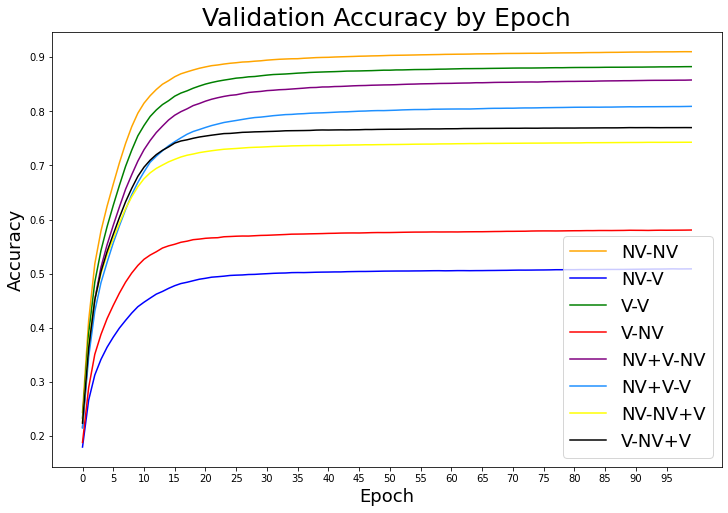

In [8]:
#Parameters

#Which subjects should be used in the experiment
selection=(1,3,5,8,10,11,12,13,15,18)
#Number of training samples per subject
n_train = 10
#Number of validation samples per subject (set to use all remianing samples after training samples have been chosen)
n_val = 20-n_train
#Conditions to be run (first element of tuple is training set, second element is validation set, tuple as element means set will be split between specfified conditions)
#0 is non-variable, 2 is variable
conditions = [("0","0"),("0","2"),("2","2"),("2","0"),(("0","2"),"0"),(("0","2"),"2"),("0",("0","2")),("2", ("0","2"))]
#Labels for conditions used for plotting and CSV export
labels = ["NV-NV","NV-V","V-V","V-NV","NV+V-NV","NV+V-V","NV-NV+V","V-NV+V"]
#Number of iterations per condition (in other words, how many models will be trained per condition)
iterations = 500
#Number of speakers, set to default to length of selection list
n_speakers = len(selection)
#Option to activate keras logging while training
log = 0
#Option to enable graphs for each individual model (NOTE: The graphs will not appear until all models have been trained)
graph = 0

results2 = [ [] for _ in range(iterations) ]
avg_results= []
results_list = []
colours = ["orange", "blue", "green", "red", "purple","dodgerblue", "yellow", "black"]

#Iterate through conditions
for i in range(len(conditions)):
    #Reset result list used for plotting average curves
    results1 = []
    
    #Iterate through number of chosen iterations per condition
    for j in range(iterations):
        
        #Creating sets
        [train_set, val_set, X_train, X_val] = create_sets(selection, n_train, n_val, conditions[i])
        
        #Pre-Processing
        [y_train, y_val, X_train, X_val] = processing(X_train, X_val, train_set, val_set)

        #Build model
        [model, early_stop] = build_model(n_speakers)

        #Train
        result = train_model(model, early_stop, log, graph)
        results1.append(result)
        result = result[99]
        results2[j].append(result)

        #Progress Counter
        print(str(1+j+i*iterations) + "/" + str(iterations * len(conditions)))
        
    #Sum accuracy from all runs
    sum_results = [0] * 100
    for i in range (0, iterations):
        sum_results = np.add(sum_results, results1[i])

    #Take average of accuracy from all runs
    avg_results.append([x / iterations for x in sum_results])

#Plot validation curves of different models
plt.figure(figsize=(12, 8))
for k in range(len(conditions)):
    plt.plot(avg_results[k], label=labels[k], color=colours[k])
plt.title('Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))
plt.legend(fontsize = 18);

#Turn list into dataframe
results_df = pd.DataFrame(results2, columns=labels)
results_df.head()

#Export dataframe as CSV file
results_df.to_csv(r'/Users/jthiepler/Documents/GitHub/voice-classifier/results.csv', index=False)